# Импортирование необходимых библиотек

In [1]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math, random, itertools
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

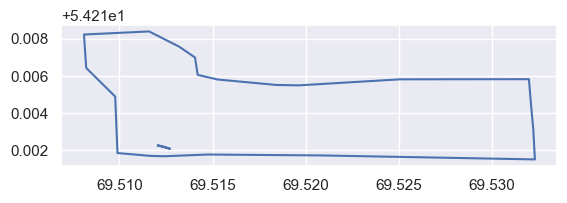

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [8]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [9]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

# Составление запросов

In [10]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
evalscript_all_bands = evalscript_all_bands.format(**settings)

In [11]:
evalscript_aux_data = """
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DEGREES"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in aux_data_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
evalscript_aux_data = evalscript_aux_data.format(**settings)

# Снимки на даты (с 01.05.2023 по 31.08.2023)

In [12]:
time_interval = "2021-05-01", "2021-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 49


In [13]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [14]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [15]:
aux_data_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_aux_data,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    aux_data_process_requests.append(request)

In [16]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 9.41 s


In [17]:
%%time

client = SentinelHubDownloadClient(config=config)
aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
aux_data = client.download(aux_data_download_requests)

Wall time: 4.69 s


# Составление маски пастбища

In [18]:
aoi_height, aoi_width = pasture_size[-1], pasture_size[0]

In [19]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

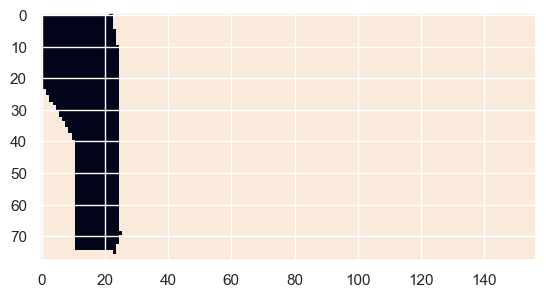

In [20]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

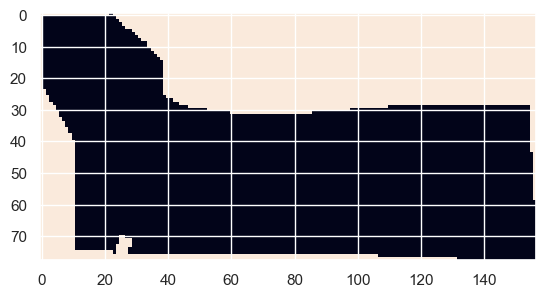

In [21]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [22]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [23]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 12246 # Количество 157*78=[0-12246]

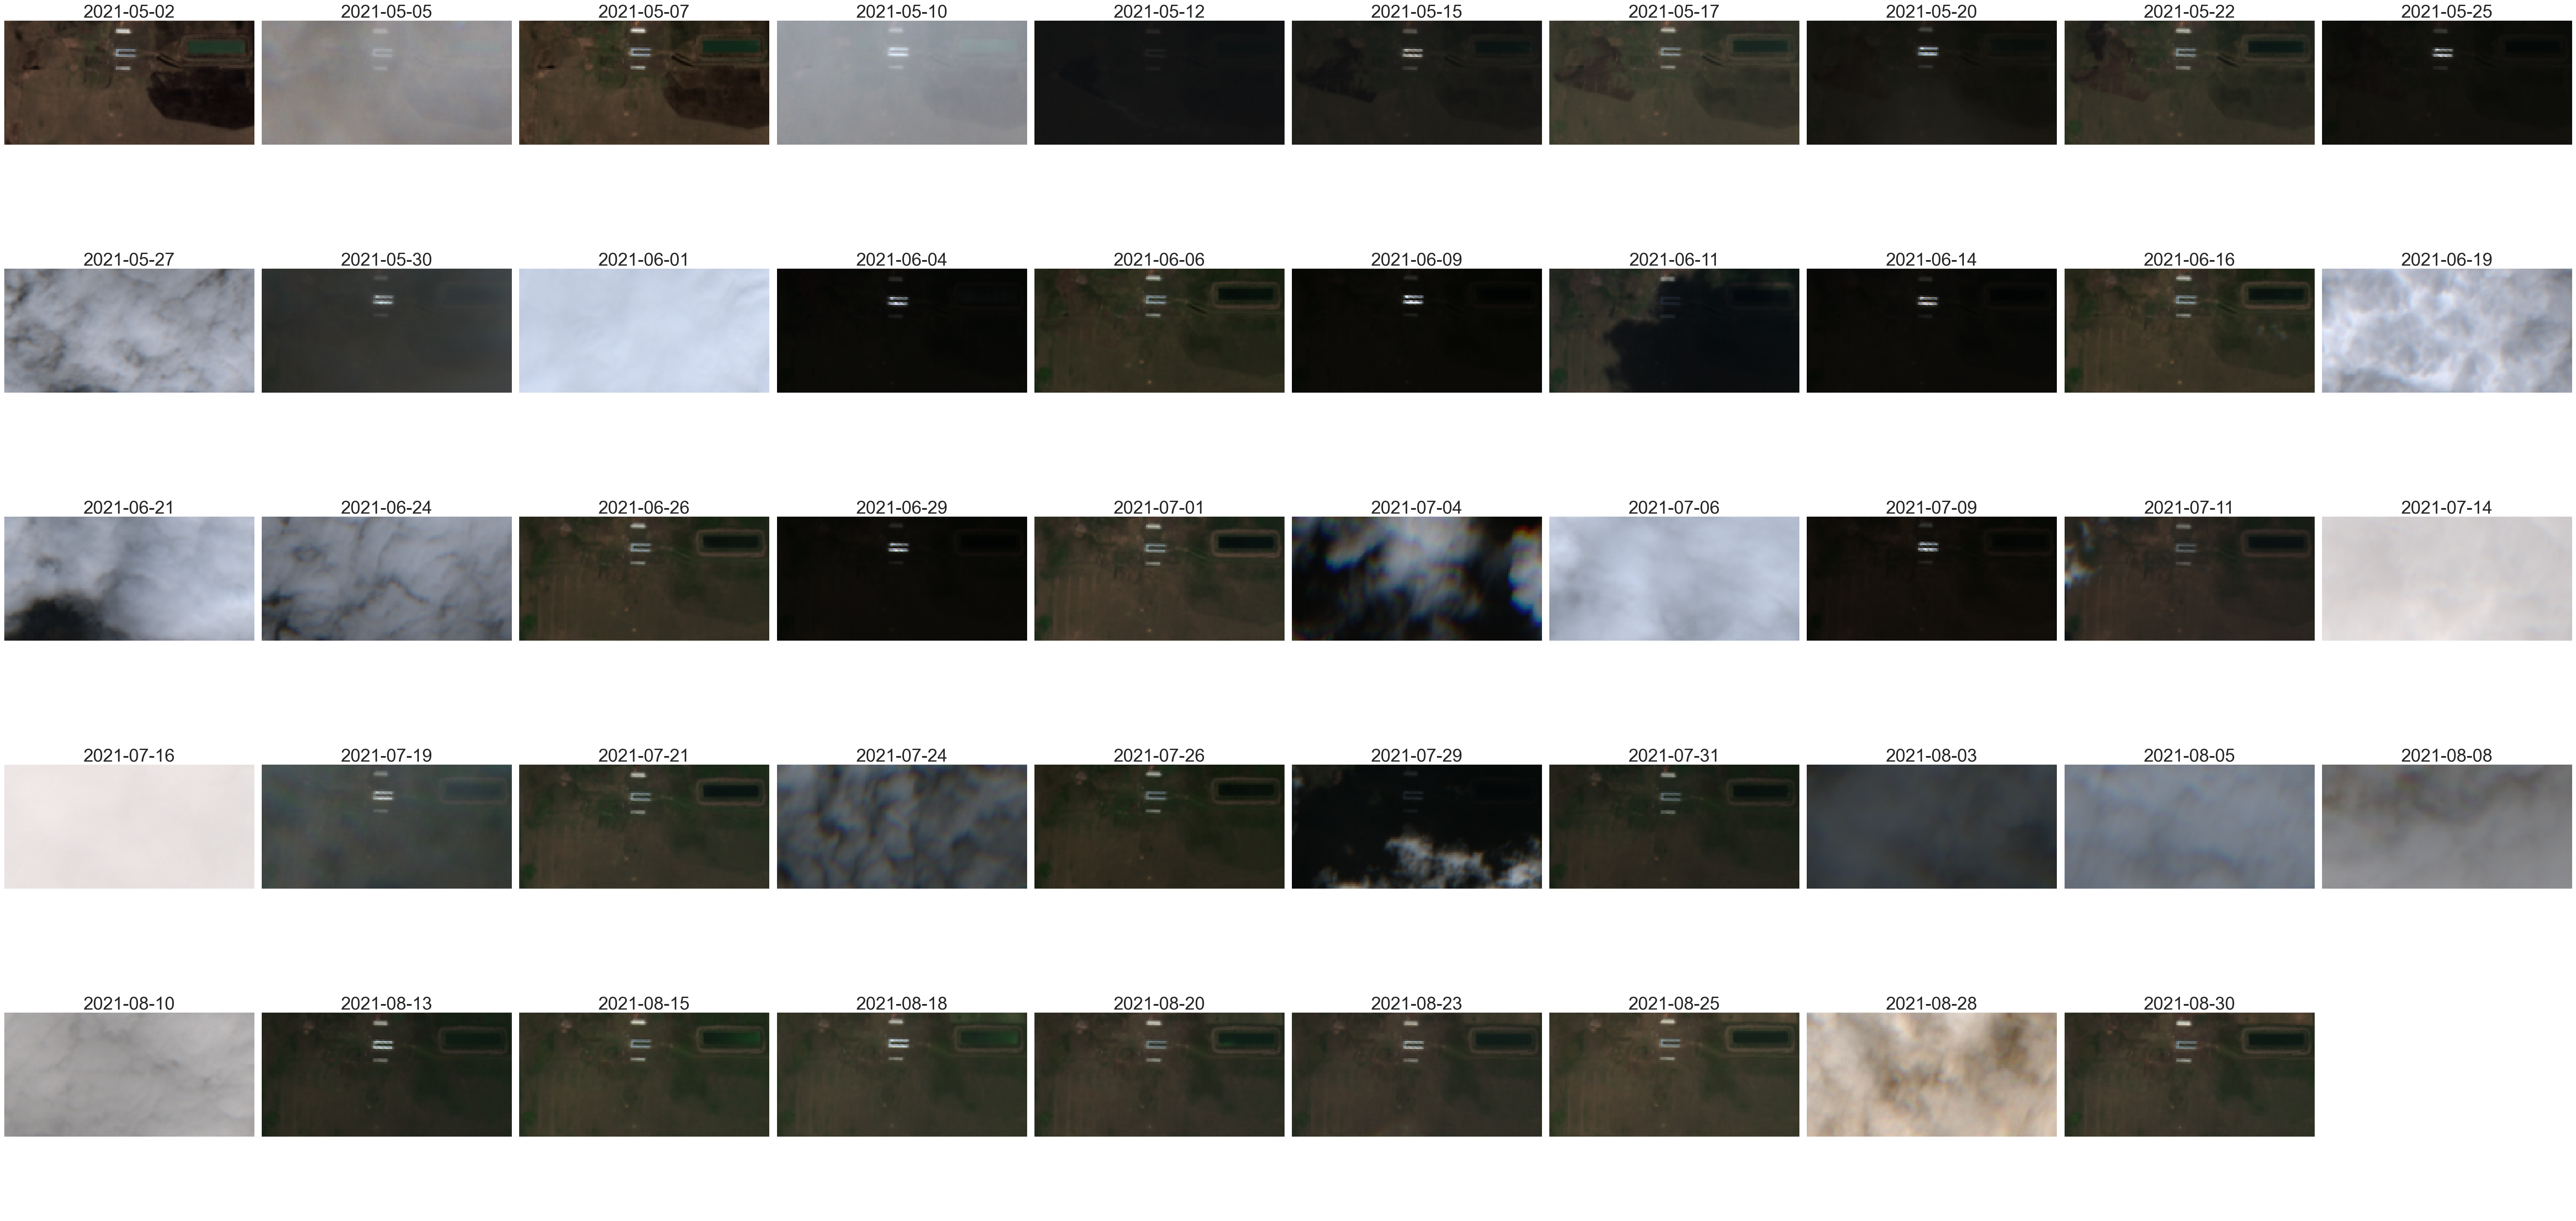

In [24]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
#     mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
#     mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
#     mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
#     comb = mx1&mx2&mx3
#     white_image = comb >= white_noise_threshold
#     if white_image.sum() <= white_noise_count:
    clear_date_dict.append((str(timestamp.date().isoformat()), i))
    ax = axis[idx // ncols][idx % ncols]
    image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_title(timestamp.date().isoformat(), fontsize=30)
    idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Выбор доступной даты 

In [25]:
date_chosen = "2021-08-15"
image_date = clear_date_dict[date_chosen]

get_all_bands(by_pasture=False)

precision = 4
general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"

# Исследование нового индекса

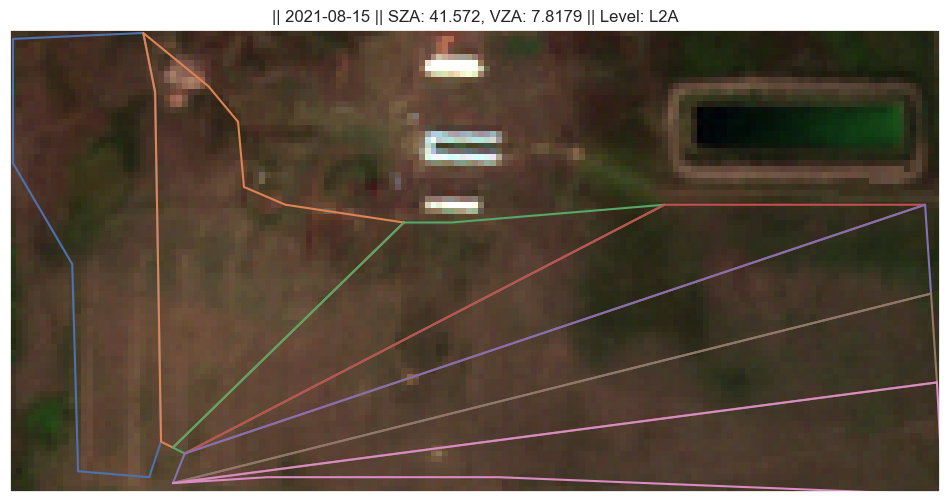

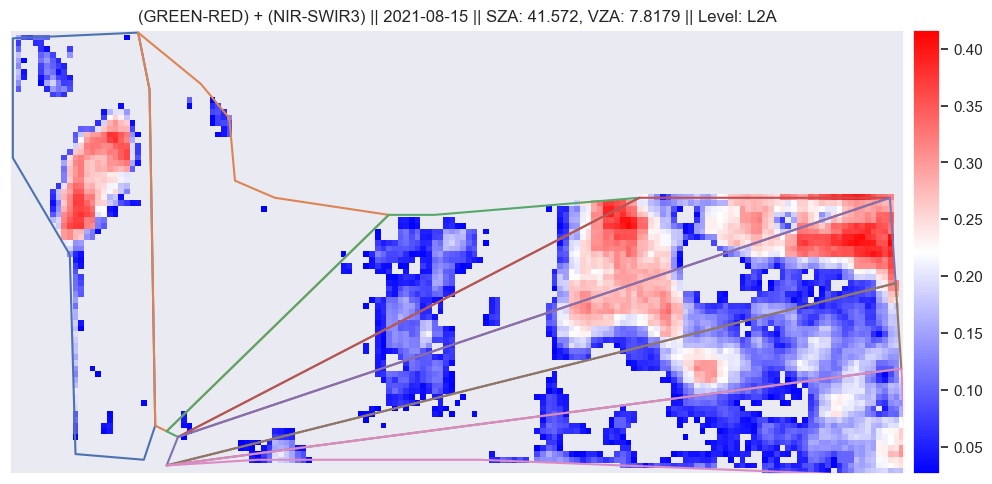

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин
№1,73.648903,0.196400,0.194800,0.379700,0.025900
№2,1.455900,0.060700,0.057900,0.127900,0.025800
№3,30.130501,0.101400,0.081600,0.393300,0.026000
№4,133.573593,0.214100,0.236500,0.411600,0.026500
№5,143.694901,0.185400,0.170100,0.416800,0.025900
№6,80.671898,0.130700,0.126000,0.315200,0.026200
№7,73.726601,0.107500,0.094500,0.305300,0.025900
Пастбище,536.902283,0.158300,0.137000,0.416800,0.025800


In [26]:
# input_text = "(NIR-RED) / (NIR+RED)"
input_text = "(GREEN-RED) + (NIR-SWIR3)"

test_index = eval(input_text)

# test_thresh = test_index.min() 
test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)

# lower_bound = -1;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()

show_real_pasture()
show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False)

# Разбивка на кластеры

In [27]:
# n_clusters = 3
# for cluster_mask in Kcluster(test_meet, n_clusters):
#     cluster = ma.masked_array(test_meet, mask=cluster_mask.reshape(aoi_height, aoi_width))
#     fig, ax = plt.subplots(figsize=(12, 12))
#     for zagon in range(len(pasture_df)-1):

#         ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

#     ep.plot_bands(cluster_mask, title=f"Кластер значении [{round(float(cluster.min()),precision)} - {round(float(cluster.max()),precision)}] канала {input_text} {general_info}", ax=ax, figsize=(10, 14))
# plt.show()

# Вывод всех каналов по отдельности

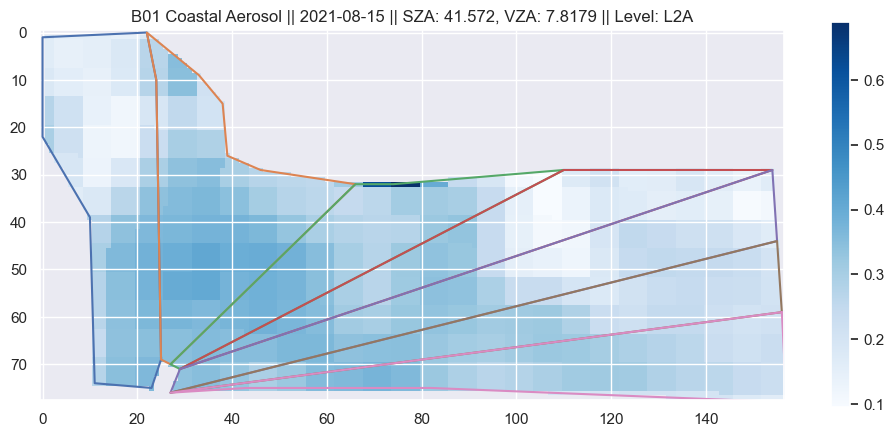

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ULTRA_BLUE, cmap="Blues", vmin=ULTRA_BLUE.min(), vmax=ULTRA_BLUE.max())
plt.title(f"B01 Coastal Aerosol {general_info}")
plt.colorbar()
plt.show()

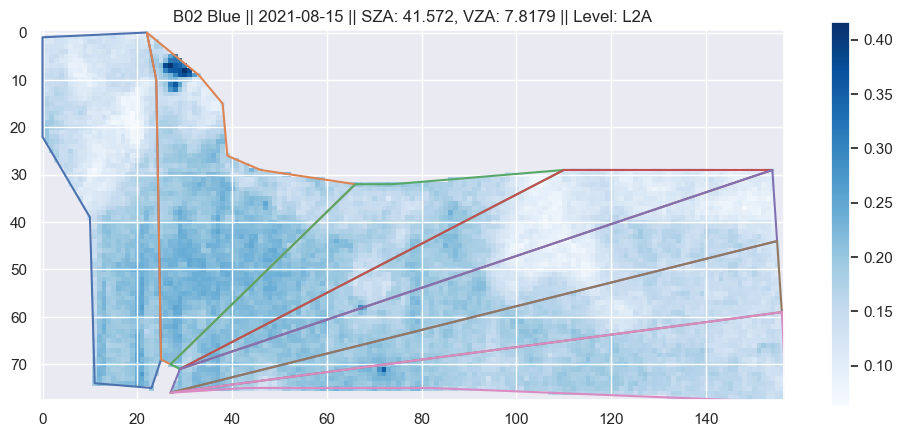

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(BLUE, cmap="Blues", vmin=BLUE.min(), vmax=BLUE.max())
plt.title(f"B02 Blue {general_info}")
plt.colorbar()
plt.show()

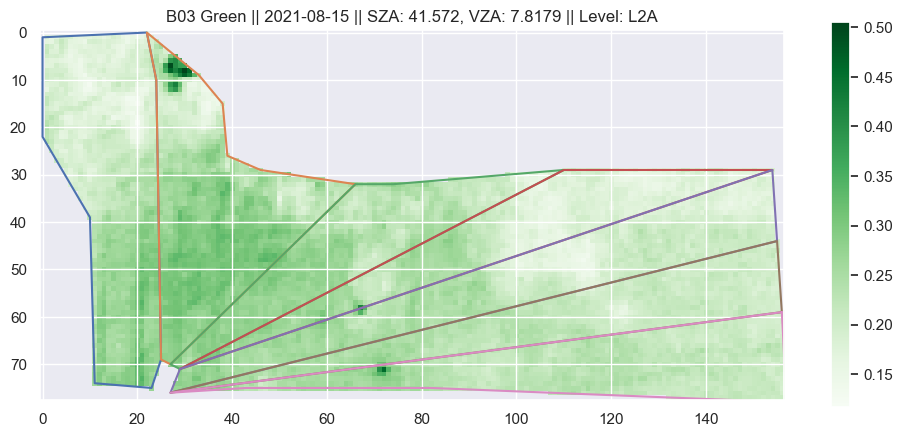

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(GREEN, cmap="Greens", vmin=GREEN.min(), vmax=GREEN.max())
plt.title(f"B03 Green {general_info}")
plt.colorbar()
plt.show()

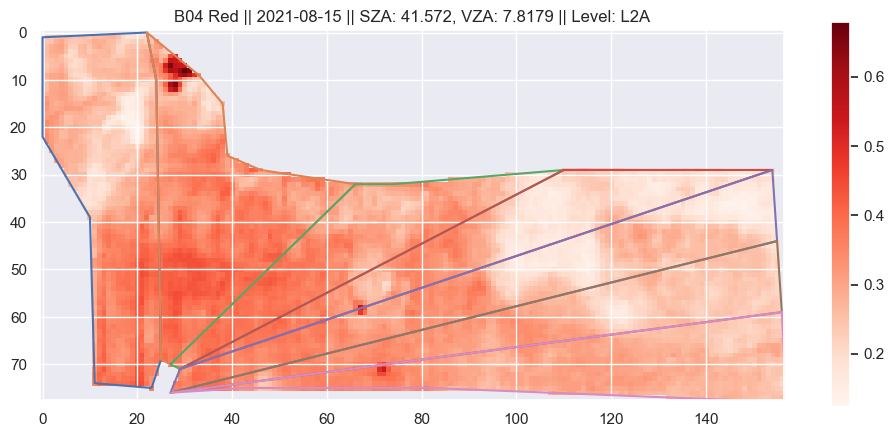

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED, cmap="Reds", vmin=RED.min(), vmax=RED.max())
plt.title(f"B04 Red {general_info}")
plt.colorbar()
plt.show()

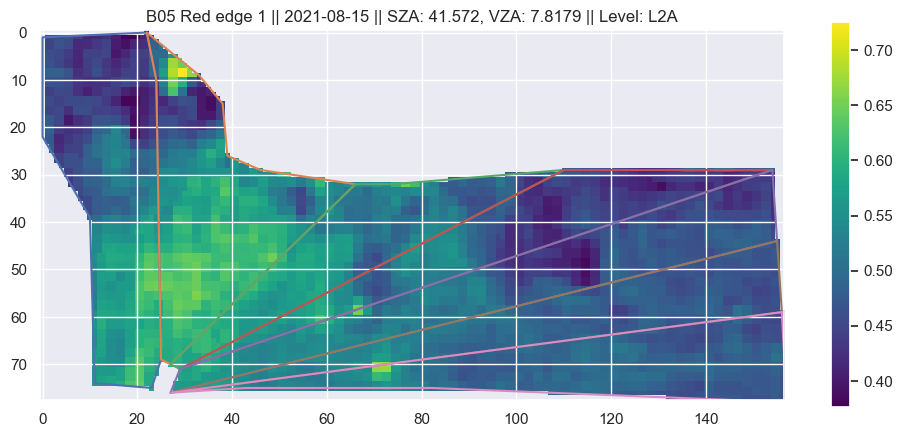

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE1, cmap="viridis", vmin=RED_EDGE1.min(), vmax=RED_EDGE1.max())
plt.title(f"B05 Red edge 1 {general_info}")
plt.colorbar()
plt.show()

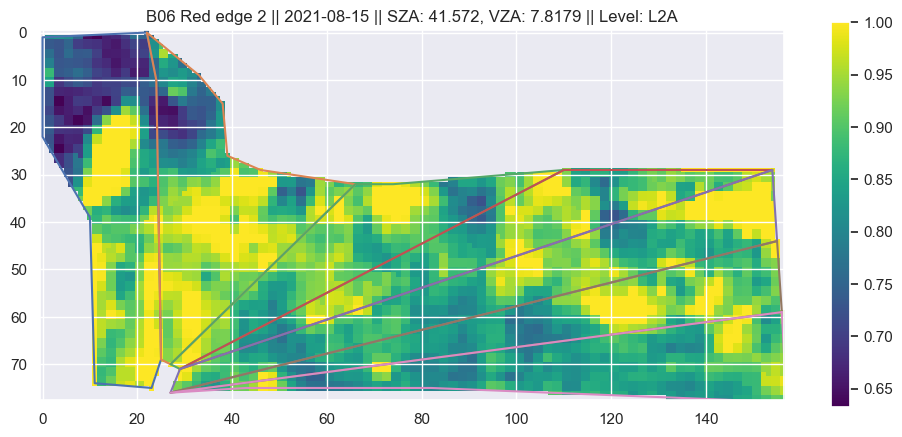

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE2, cmap="viridis", vmin=RED_EDGE2.min(), vmax=RED_EDGE2.max())
plt.title(f"B06 Red edge 2 {general_info}")
plt.colorbar()
plt.show()

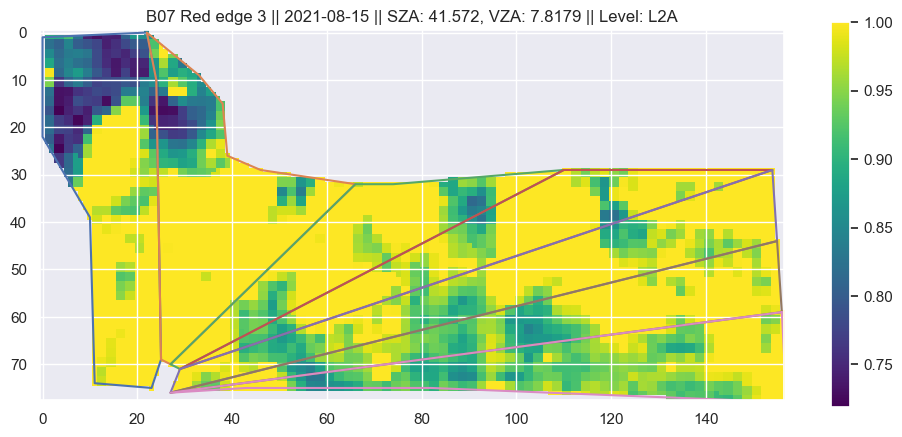

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE3, cmap="viridis", vmin=RED_EDGE3.min(), vmax=RED_EDGE3.max())
plt.title(f"B07 Red edge 3 {general_info}")
plt.colorbar()
plt.show()

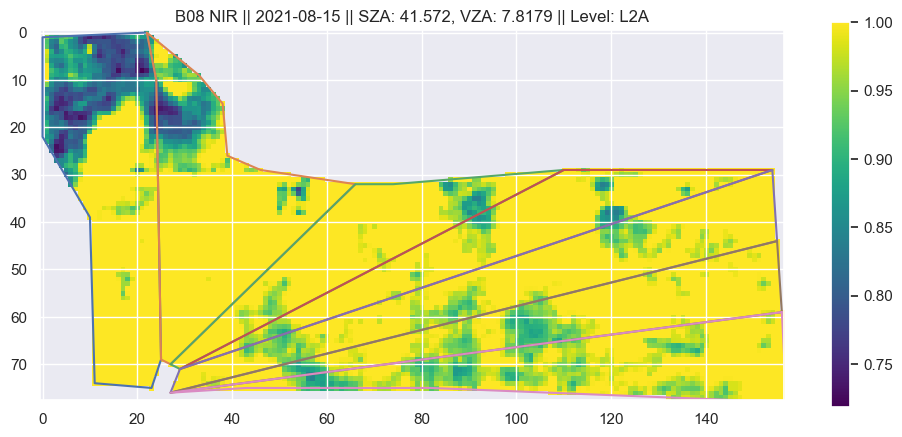

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(NIR, cmap="viridis", vmin=NIR.min(), vmax=NIR.max())
plt.title(f"B08 NIR {general_info}")
plt.colorbar()
plt.show()

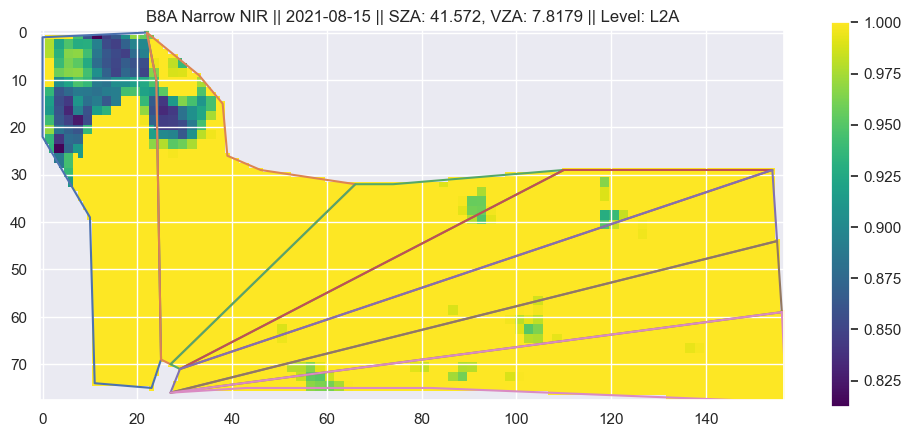

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(N_NIR, cmap="viridis", vmin=N_NIR.min(), vmax=N_NIR.max())
plt.title(f"B8A Narrow NIR {general_info}")
plt.colorbar()
plt.show()

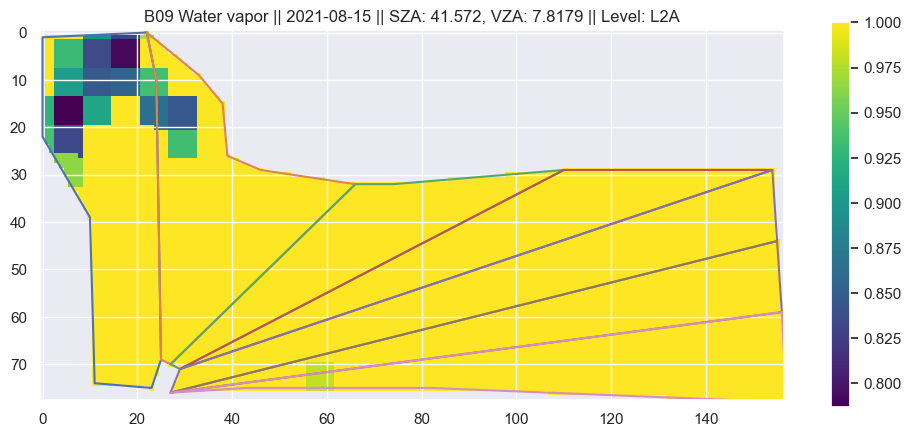

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(WV, cmap="viridis", vmin=WV.min(), vmax=WV.max())
plt.title(f"B09 Water vapor {general_info}")
plt.colorbar()
plt.show()

In [38]:
if "B10" in bands_dict:
    fig, ax = plt.subplots(figsize=(12, 5))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    plt.imshow(SWIR_C, cmap="viridis", vmin=SWIR_C.min(), vmax=SWIR_C.max())
    plt.title(f"B10 SWIR C {general_info}")
    plt.colorbar()
    plt.show()

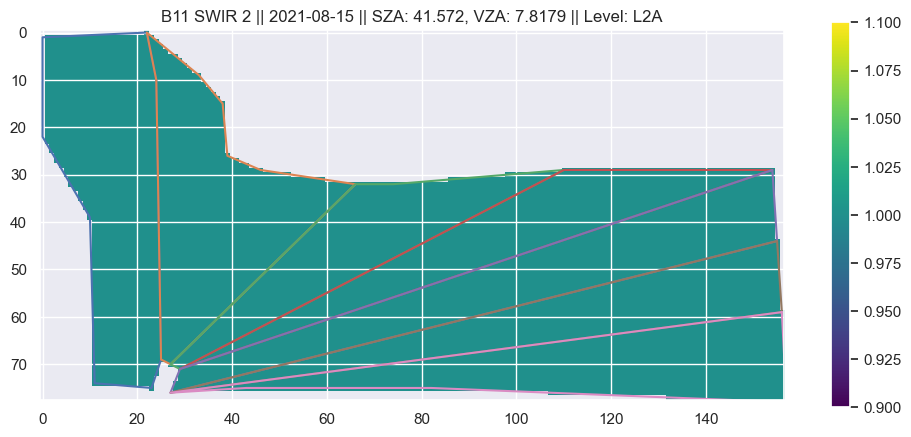

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR2, cmap="viridis", vmin=SWIR2.min(), vmax=SWIR2.max())
plt.title(f"B11 SWIR 2 {general_info}")
plt.colorbar()
plt.show()

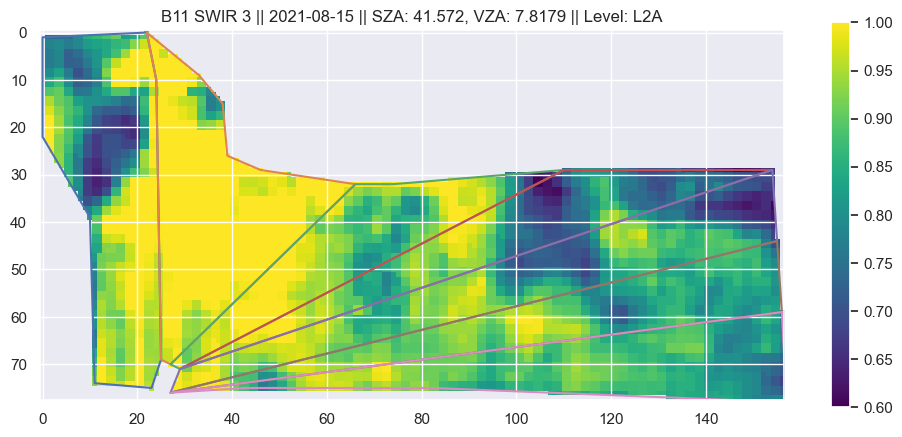

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR3, cmap="viridis", vmin=SWIR3.min(), vmax=SWIR3.max())
plt.title(f"B11 SWIR 3 {general_info}")
plt.colorbar()
plt.show()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [41]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [42]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
#     print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
#         print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [43]:
def get_date_data(date_chosen, collection, by_pasture=True, median=False):
    global bands_dict

    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)


    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    ndvi = (NIR - RED) / (NIR + RED)
    savi = (NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5)
    revi = (NIR / RED_EDGE1) - 1
    evi = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)
    tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)
    gndvi = (NIR - GREEN) / (NIR + GREEN)
    ndii = (NIR - SWIR3) / (NIR + SWIR3)
    cvi = (NIR / RED) - 1
    gci = (NIR / GREEN) - 1
    pri = (RED_EDGE1 - RED) / (RED_EDGE1 + RED)
    ndre = (NIR - RED_EDGE1) / (NIR + RED_EDGE1)
    osavi = (NIR - RED) / (NIR + RED + 0.16)
    arvi = (NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)
    vari = (RED+BLUE-GREEN)
    my_index = (GREEN-RED)+(NIR-SWIR3)



    print(f"Успешно получены каналы для даты: {date_chosen}")
    if median:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR_C), ma.median(SWIR2), ma.median(SWIR3), ma.median(ndvi), ma.median(savi), ma.median(revi), ma.median(evi), ma.median(tvi), ma.median(gndvi), ma.median(ndii), ma.median(cvi), ma.median(gci), ma.median(pri), ma.median(ndre), ma.median(osavi), ma.median(arvi), ma.median(vari), ma.median(my_index), SZA, SAA, VZM, VAM]
        else:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR2), ma.median(SWIR3), ma.median(ndvi), ma.median(savi), ma.median(revi), ma.median(evi), ma.median(tvi), ma.median(gndvi), ma.median(ndii), ma.median(cvi), ma.median(gci), ma.median(pri), ma.median(ndre), ma.median(osavi), ma.median(arvi), ma.median(vari), ma.median(my_index), SZA, SAA, VZM, VAM]
    else:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR_C), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(ndvi), ma.mean(savi), ma.mean(revi), ma.mean(evi), ma.mean(tvi), ma.mean(gndvi), ma.mean(ndii), ma.mean(cvi), ma.mean(gci), ma.mean(pri), ma.mean(ndre), ma.mean(osavi), ma.mean(arvi), ma.mean(vari), ma.mean(my_index), SZA, SAA, VZM, VAM]
        else:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(ndvi), ma.mean(savi), ma.mean(revi), ma.mean(evi), ma.mean(tvi), ma.mean(gndvi), ma.mean(ndii), ma.mean(cvi), ma.mean(gci), ma.mean(pri), ma.mean(ndre), ma.mean(osavi), ma.mean(arvi), ma.mean(vari), ma.mean(my_index), SZA, SAA, VZM, VAM]

# Выбор диапазона дат выпаса

In [44]:
start_date = "2023-05-01"
end_date = "2023-08-31"

start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
grazing_duration = end_date - start_date

# Модуляция роста растении

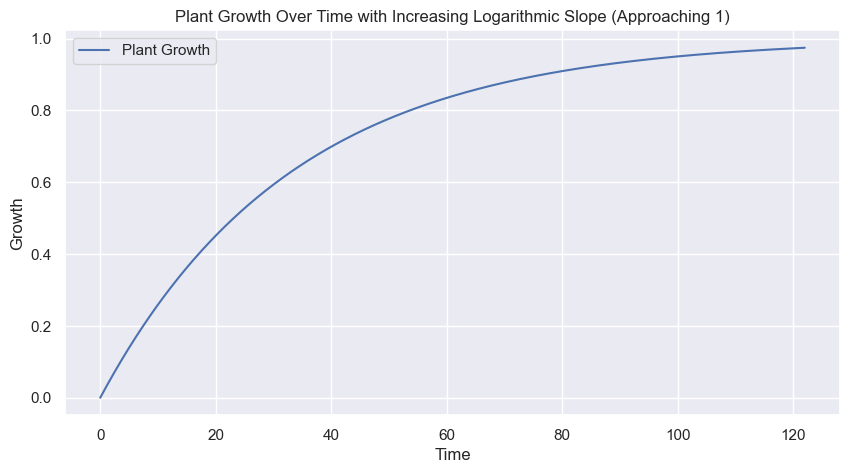

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the growth model
max_growth = 1.0  # Maximum growth (1.0 means reaching 1 but not exceeding it)
scaling_factor = 0.03  # Adjust the scaling factor to control the rate of growth

# Generate data for plant growth
x = np.linspace(0, grazing_duration.days, 1000)  # Adjust the range and number of points as needed

# Use the logarithmic function with scaling factor to model plant growth
y = max_growth * (1 - np.exp(-scaling_factor * x))

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Plant Growth")
plt.xlabel("Time")
plt.ylabel("Growth")
plt.title("Plant Growth Over Time with Increasing Logarithmic Slope (Approaching 1)")

plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Общий рост по сезону

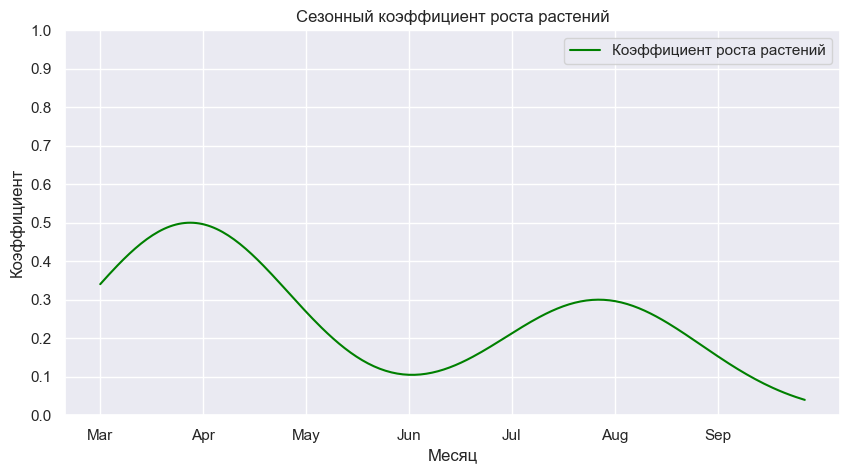

In [46]:
season_start_date = "2023-03-01"
season_end_date = "2023-09-30"
season_start_date = datetime.datetime.strptime(season_start_date, "%Y-%m-%d")
season_end_date = datetime.datetime.strptime(season_end_date, "%Y-%m-%d")
season_duration = season_end_date - season_start_date

first_peak = "2023-04-01"; max1_y = 0.5
second_peak = "2023-08-20"; max2_y = 0.3

first_peak = datetime.datetime.strptime(first_peak, "%Y-%m-%d")
second_peak = datetime.datetime.strptime(second_peak, "%Y-%m-%d")


# Define the two maximum points
max1_x = (first_peak - season_start_date).days  # x value of the first maximum point
max2_x = (second_peak - season_start_date).days  # x value of the second maximum point


# Generate x values (months)
x = np.linspace(0, season_duration.days+30, season_duration.days+30)  # Adjust the range as needed

sigma = 50  # Increase this value to make the curve less steep

# Calculate the y values based on the Gaussian distribution for the two maxima
y = max1_y * np.exp(-((x - max1_x) / sigma) ** 2) + max2_y * np.exp(-((x - max2_x) / sigma) ** 2)

# Initialize an empty list to store month labels
custom_x_ticks = []

# Generate month labels for each month in the season duration
current_date = season_start_date
while current_date <= season_end_date:
    custom_x_ticks.append(current_date.strftime("%b"))
    current_date = current_date + datetime.timedelta(days=30)  # Approximate number of days in a month

# Ensure the last label is "Sep" to match the season end date

# Remove duplicate month labels if any
custom_x_ticks = list(set(custom_x_ticks))

# Sort the month labels in chronological order
custom_x_ticks.sort(key=lambda x: datetime.datetime.strptime(x, "%b").month)
# Calculate the positions of the custom x ticks
# In this case, I'm spreading them evenly across the x-axis
custom_x_tick_positions = np.linspace(0, season_duration.days, len(custom_x_ticks))

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Коэффициент роста растений", color="green")
plt.xlabel("Месяц")
plt.ylabel("Коэффициент")
plt.title("Сезонный коэффициент роста растений")

max_y_tick = 1.0  # Adjust this value as needed
plt.yticks(np.arange(0, max_y_tick + 0.1, 0.1))  # Set y ticks from 0 to max_y_tick

# Set the custom x tick positions and labels
plt.xticks(custom_x_tick_positions, custom_x_ticks)

plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Фаза роста растения(ий)

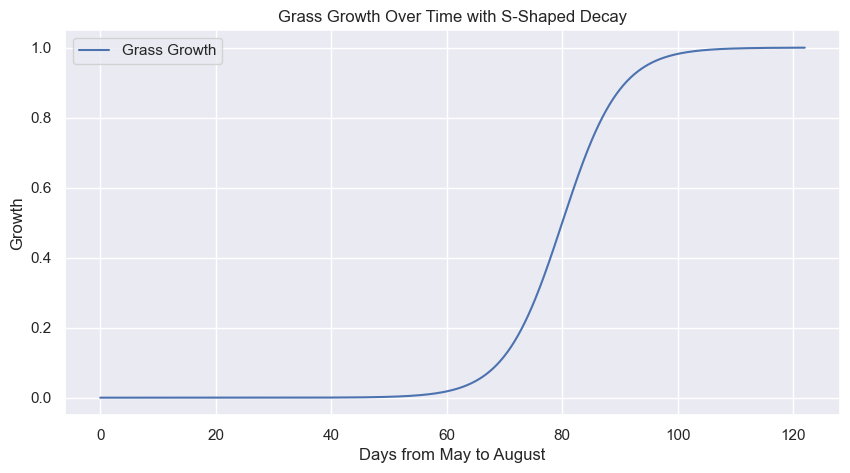

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data
x = np.linspace(0, grazing_duration.days, 1000)  # Adjust the range and number of points as needed

# Define parameters for the sigmoid function
growth_rate = 0.2
midpoint = 80
plateau_value = 1

# Model grass growth with a sigmoid function
y = plateau_value / (1 + np.exp(-growth_rate * (x - midpoint)))

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Grass Growth")
plt.xlabel("Days from May to August")
plt.ylabel("Growth")
plt.title("Grass Growth Over Time with S-Shaped Decay")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Модуляция поедания растении

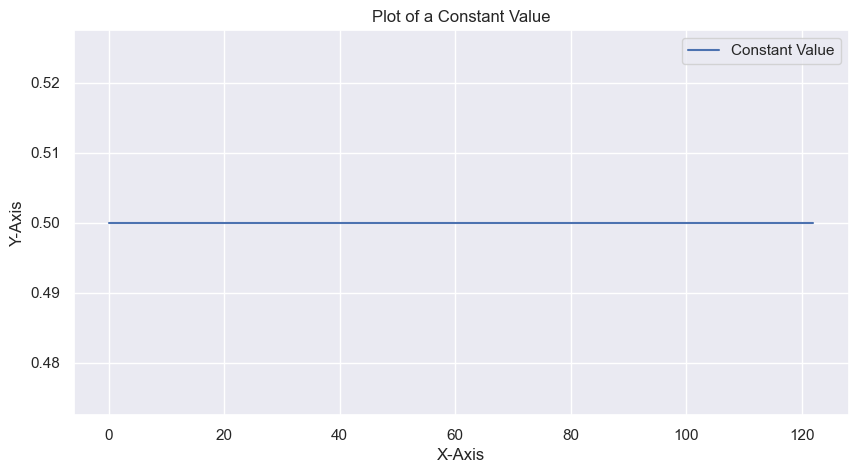

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define a constant value
constant_value = 0.5

# Create an array with the constant value
x = np.linspace(0, grazing_duration.days, 1000)  # Adjust the range and number of points as needed
constant_data = np.full_like(x, constant_value)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, constant_data, label="Constant Value")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("Plot of a Constant Value")

plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Модуляция отмирания растении

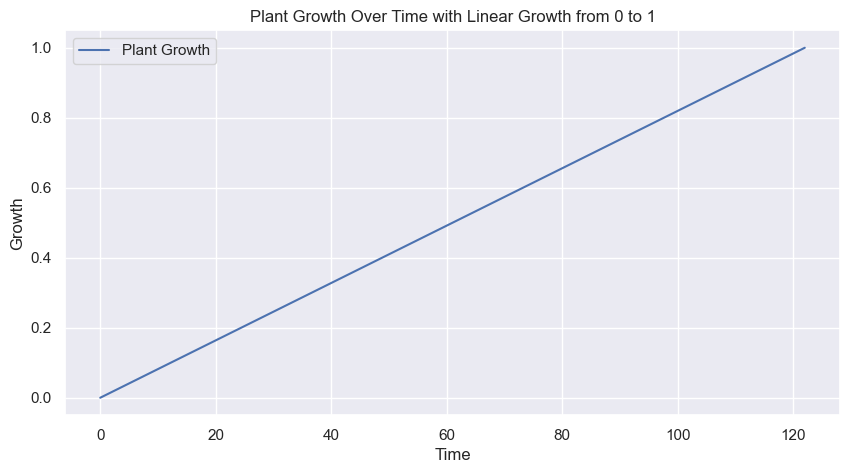

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data for plant growth
x = np.linspace(0, grazing_duration.days, 1000)  # Adjust the range and number of points as needed

# Use a linear function to model plant growth
y = x / grazing_duration.days  # Linear growth from 0 to 1

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Plant Growth")
plt.xlabel("Time")
plt.ylabel("Growth")
plt.title("Plant Growth Over Time with Linear Growth from 0 to 1")

plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Симуляция параметров пастбища и поведения скота

## Вспомогательные функции

In [50]:
breed_factors = {
    "Angus": 0.025,
    "Hereford": 0.026,
    "Limousin": 0.028,
    "Charolais": 0.029,
}

def estimated_daily_weight_gain(initial_weight, age_in_months, breed_type):
    A = 0.025
    B = int(np.interp(age_in_months, [12, 24], [20, 80]))
    C = breed_factors.get(breed_type, 0.027)
    DWG = A * (initial_weight - B) * C
    return round(DWG, 4)

def dry_matter_intake(initial_weight, breed_type):
    D = breed_factors.get(breed_type, 0.027)
    DMI = D * initial_weight
    return round(DMI, 4)

In [51]:
class TimeLine:
    watcher = dict()
    
class Cattle():
    cattle_count = 0
    cattle_stack = []
    
    def __init__(self, sex, weight, stage=None, breed="Angus", production="beef", age=12, forage_to_gain=0.25):
        self.breed = breed           # Порода
        self.sex = sex               # Пол: Корова/Бык
        self.production = production # Направление: Молочное/Мясное
        self.age = age               # Возраст
        self.stage = stage           # Стадия/период
        self.weight = weight         # Начальный вес
        
        self.current_paddock = None
        self.day_entered = None
        
        self.gps_coordinate = None
        
        self.already_consumed_forage = 0
        self.forage_needed = None
        self.forage_to_gain = forage_to_gain # 1 кг сухой массы = 0.25 кг прирост в массе
        
        self.forage_needed = dry_matter_intake(self.weight, self.breed)
        
        Cattle.cattle_count += 1
        Cattle.cattle_stack.append(self)
        self.index = Cattle.cattle_count
    
        self.weight_history = []
        self.forage_needed_history = []
        
    def update_age(self, grazing_day):
        if grazing_day % 30 == 0:
            self.age += 1
    
    def update_weight(self):
        weight_gain = estimated_daily_weight_gain(self.weight, self.age, self.breed)
        self.weight += weight_gain
        
    def update_forage_consumption(self):
        self.forage_needed = dry_matter_intake(self.weight, self.breed)
        
            
            
    def __str__(self):
        return f'Cattle №{self.index}. Already consumed: {self.already_consumed_forage} kg. In the paddock №{self.current_paddock} right now.'
    def __repr__(self):
        return f'Cattle №{self.index}. Already consumed: {self.already_consumed_forage} kg. In the paddock №{self.current_paddock} right now.'
    
    def enter_into_paddock(new_paddock_number):
        self.current_paddock = new_paddock_number
        self.day_entered = datetime.datetime.today()
        
    
    def get_gps_coordinate_request(self):
        # Making a request to intermediate module of the system
        # Obtaining GPS coordinates of an interested cattle 
        self.gps_coordinate = (0, 0)
        return self.gps_coordinate
    
    def get_cattle_current_gps_coordinates(self):
        gps_coordinate = self.get_gps_coordinate_request()
        curr_coord_y, curr_coord_x = gps_coordinate # (Latitude, Longitude) = (54.216885, 69.517046)
        x = int(np.interp(curr_coord_x, [x_min, x_max], [0, aoi_width])) # 157
        y = int(np.interp(curr_coord_y, [y_min, y_max], [aoi_height, 0])) # 78

        print(f"Координаты: {curr_coord_y}, {curr_coord_x} || Пиксельный эквивалент: {y}, {x}")
        for i, paddock in enumerate(masks, start=1):
            if not paddock.reshape(aoi_height, aoi_width)[y, x]:
                self.current_paddock = i
            else:
                self.current_paddock = None
    
    
class Plant():
    
    def __init__(self, name, growth_rate, death_rate, 
                 temperature_range, moisture_range, radiation_range,
                 season_start_date = "2023-03-01",
                 season_end_date = "2023-09-30",
                 first_peak = "2023-04-01", max1_y = 0.9,
                 second_peak = "2023-08-20", max2_y = 0.6,
                 sigma = 50,
                 plant_density = 150, # кг/м3
                ):
        self.name = name
        
        self.growth_rate = growth_rate # мм/день  
        self.death_rate = death_rate   # мм/день
        
        self.temperature_range = temperature_range
        self.moisture_range = moisture_range
        self.radiation_range = radiation_range
        self.score_range = input_values = [0, 1, 0]
        
        self.max1_y = max1_y
        self.max2_y = max2_y
        self.sigma = sigma
        self.plant_density = plant_density
                        
        self.season_start_date = datetime.datetime.strptime(season_start_date, "%Y-%m-%d")
        self.season_end_date = datetime.datetime.strptime(season_end_date, "%Y-%m-%d")
        self.season_duration = self.season_end_date - self.season_start_date

        self.first_peak = datetime.datetime.strptime(first_peak, "%Y-%m-%d")
        self.second_peak = datetime.datetime.strptime(second_peak, "%Y-%m-%d")
        
        
    def get_condition_score(self, grazing_day):
#         grazing_day = datetime.datetime.strptime(grazing_day, "%Y-%m-%d")
        start_date = grazing_day + datetime.timedelta(-15)
        end_date = grazing_day + datetime.timedelta(+15)
        
#         Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date.date()}&end_date={end_date.date()}"
#         Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)
#         history_json_obj = make_API_request(Hist_URL)
#         history_df = pd.DataFrame(history_json_obj["daily"])
#         history_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)
        
        filtered_df = Plant.history_df[(Plant.history_df['time'] >= str(start_date)) & (Plant.history_df['time'] <= str(end_date))]

        temperature = np.array((filtered_df['temperature_2m_max'] + filtered_df['temperature_2m_min']) / 2)
        precipitation = np.array(filtered_df['precipitation_sum'])
        radiation = np.array(filtered_df['shortwave_radiation_sum'])
        
        temperature_score = np.interp(temperature, self.temperature_range, self.score_range, left=self.score_range[0], right=self.score_range[-1]).mean()
        precipitation_score = np.interp(precipitation, self.moisture_range, self.score_range, left=self.score_range[0], right=self.score_range[-1]).mean()
        radiation_score = np.interp(radiation, self.radiation_range, self.score_range, left=self.score_range[0], right=self.score_range[-1]).mean()
                
        return np.array([temperature_score, precipitation_score, radiation_score]).mean()
        
        
    def get_seasonal_score(self, grazing_day):
#         grazing_day = datetime.datetime.strptime(grazing_day, "%Y-%m-%d")
        days_passed = (grazing_day - self.season_start_date).days
        
        self.max1_x = (self.first_peak - self.season_start_date).days  # x value of the first maximum point
        self.max2_x = (self.second_peak - self.season_start_date).days  # x value of the second maximum point

        self.x = np.linspace(0, self.season_duration.days, self.season_duration.days)  # Adjust the range as needed

        self.sigma = 50  # Increase this value to make the curve less steep

        self.y = self.max1_y * np.exp(-((self.x - self.max1_x) / self.sigma) ** 2) + self.max2_y * np.exp(-((self.x - self.max2_x) / self.sigma) ** 2)

        return self.y[days_passed]
        
        
class Soil():
    
    def __init__(self, soil_type, humus_content, acidity, potassium_content, phosphorus_content, nitrogen_content):
        self.soil_type = soil_type 
        self.humus_content = humus_content
        self.acidity = acidity
        self.potassium_content = potassium_content
        self.phosphorus_content = phosphorus_content
        self.nitrogen_content = nitrogen_content

        
        
class Grazing():
    
    def __init__(self,  start_date, end_date, pasture, num_rounds=2):
        self.pasture = pasture
        self.num_rounds = num_rounds
        self.start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
        self.end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
        self.grazing_duration = self.end_date - self.start_date
        self.grazing_cycle = itertools.cycle(range(1, len(self.pasture.paddock_masks)+1))
        value = next(self.grazing_cycle)
        setattr(self.pasture, "grazing_cycle", self.grazing_cycle)
        setattr(self.pasture, "start_date", self.start_date)
        setattr(self.pasture, "end_date", self.end_date)
        setattr(self.pasture, "grazing_duration", self.grazing_duration)
        self.preload_weather_df()
        
    def preload_weather_df(self):
        start_date = self.start_date + datetime.timedelta(-20)
        end_date = self.end_date + datetime.timedelta(+20)
        
        Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date.date()}&end_date={end_date.date()}"
        Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)
        history_json_obj = make_API_request(Hist_URL)
        history_df = pd.DataFrame(history_json_obj["daily"])
        history_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)
        Plant.history_df = history_df
        
    def start_grazing(self):
        print("Grazing started!")
        for day in range(self.grazing_duration.days):
            current_date = self.start_date + datetime.timedelta(days=day)
#             print("Date: ", current_date.date())
            self.pasture.update_paddock_resource(current_date)
        print("Grazing finished!")
        
    
class Pasture():
    
    def __init__(self, size, paddock_masks):
        self.size = size
        self.paddock_masks = paddock_masks
        self.currently_grazed_paddock = None
        
        self.create_paddocks()
        
    def botanical_composition(self, paddock, plants_dict):
        if sum([percentage[1] for percentage in plants_dict.values()]) > 100:
            raise TypeError(f"100 < {sum([percentage[1] for percentage in plants_dict.values()])}")
            return
        setattr(self, f"paddock_{paddock}_plants", plants_dict)
    
    def set_paddock_resource(self, paddock, resource):
        setattr(self, f"paddock_{paddock}_resource", resource)
        
    def update_paddock_resource(self, grazing_day):
        for paddock, mask in enumerate(self.paddock_masks, start=1):
            plants_dict = getattr(self, f"paddock_{paddock}_plants")
            daily_forage_consumption = self.get_paddocks_daily_forage_consumption(paddock, grazing_day)
            
            daily_green_mass_delta = 0
            for plant, [obj, percentage] in plants_dict.items():
                number_of_squares = round(sum(~self.paddock_masks[paddock-1])*percentage/100)
                GI = obj.get_condition_score(grazing_day)
                SI = obj.get_seasonal_score(grazing_day)
                coeff = (GI+SI)/2; inv_coeff = 1-(GI+SI)/2
                green_mass_daily_increment = (random.uniform(10*coeff,10)*random.uniform(10*coeff,10))*(coeff*obj.growth_rate/1000)*obj.plant_density; # kg
                green_mass_daily_decrement = (random.uniform(10*inv_coeff,10)*random.uniform(10*inv_coeff,10))*(inv_coeff*obj.death_rate/1000)*obj.plant_density; # kg
                daily_green_mass_delta += (green_mass_daily_increment - green_mass_daily_decrement)
            
            paddock_resource = getattr(self, f"paddock_{paddock}_resource")
            TimeLine.watcher[f"paddock_{paddock}_resource_history"].append(paddock_resource)
            paddock_resource = round(paddock_resource + (daily_green_mass_delta - daily_forage_consumption))
            
            self.check_current_paddock_resource(self.currently_grazed_paddock)

            self.set_paddock_resource(paddock, paddock_resource)
            
    def check_current_paddock_resource(self, paddock_number):
        paddock_current_resource = getattr(self, f"paddock_{paddock_number}_resource")
        first_paddock_resource = TimeLine.watcher[f"paddock_{paddock_number}_resource_history"][0]
        if first_paddock_resource * 0.3 > paddock_current_resource:
#         if paddock_current_resource < 5000:
            next_paddock_number = next(self.grazing_cycle)
            for cattle in Cattle.cattle_stack:
                self.add_cattle_into_paddock(cattle, next_paddock_number)
    
        
    def create_paddocks(self):
        for i, _ in enumerate(self.paddock_masks, start=1):
            setattr(self, f"paddock_{i}", [])
            TimeLine.watcher[f"paddock_{i}_resource_history"] = []
            
    def add_cattle_into_paddock(self, cattle, paddock_number):
        
        if cattle.current_paddock != paddock_number:
            if cattle.current_paddock:
                old_paddock = getattr(self, f"paddock_{cattle.current_paddock}")
                updated_old_paddock = [ocattle for ocattle in old_paddock if ocattle["object"].index != cattle.index]
                setattr(self, f"paddock_{cattle.current_paddock}", updated_old_paddock)
                
            cattle.current_paddock = paddock_number
            cattle_dict = dict();
            cattle_dict["id"] = cattle.index
            cattle_dict["object"] = cattle
            cattle_dict["paddock_number"] = cattle.current_paddock
            cattle_dict["forage_needed"] = cattle.forage_needed
            cattle_dict["already_consumed_forage"] = cattle.already_consumed_forage
            
            new_paddock = getattr(self, f"paddock_{paddock_number}")
            new_paddock.append(cattle_dict)
            self.currently_grazed_paddock = paddock_number
        else:
            print(f"{cattle} was sent to the same paddock!")
            
    def get_paddocks_daily_forage_consumption(self, paddock_number, grazing_day):
        total_forage_daily_consumption = 0
        for cattle in getattr(self, f"paddock_{paddock_number}"):
            total_forage_daily_consumption += cattle["object"].forage_needed
             
            cattle["object"].update_age((grazing_day - self.start_date).days)
            cattle["object"].update_weight()
            cattle["object"].update_forage_consumption()
            
            cattle["object"].weight_history.append(cattle["object"].weight)
            cattle["object"].forage_needed_history.append(cattle["object"].forage_needed)
            
        return total_forage_daily_consumption

In [52]:
pasture = Pasture(pasture_size, masks)

In [53]:
polyn = Plant("polyn", 7, 8, [-5, 20, 40], [0, 5, 100], [0, 20, 100], 
                 first_peak = "2023-05-11", max1_y = 0.8,
                 second_peak = "2023-08-25", max2_y = 0.5,
                 sigma = 55,
                 plant_density = 160)
typchak = Plant("typchak", 5, 6, [-5, 23, 40], [0, 7, 100], [0, 25, 100], 
                 first_peak = "2023-05-30", max1_y = 0.7,
                 second_peak = "2023-07-30", max2_y = 0.3,
                 sigma = 45,
                 plant_density = 200)
ovsyanitsa = Plant("ovsyanitsa", 10, 11, [-5, 19, 40], [0, 2, 100], [0, 15, 100], 
                 first_peak = "2023-06-08", max1_y = 0.6,
                 second_peak = "2023-08-10", max2_y = 0.4,
                 sigma = 60,
                 plant_density = 120)

In [54]:
pasture.botanical_composition(1, {"polyn": [polyn, 30], 
                                  "typchak": [typchak, 30], 
                                  "ovsyanitsa": [ovsyanitsa, 30],})
pasture.botanical_composition(2, {"polyn": [polyn, 80], 
                                  "typchak": [typchak, 10], 
                                  "ovsyanitsa": [ovsyanitsa, 10],})
pasture.botanical_composition(3, {"polyn": [polyn, 70], 
                                  "typchak": [typchak, 10], 
                                  "ovsyanitsa": [ovsyanitsa, 10],})
pasture.botanical_composition(4, {"polyn": [polyn, 60], 
                                  "typchak": [typchak, 30], 
                                  "ovsyanitsa": [ovsyanitsa, 10],})
pasture.botanical_composition(5, {"polyn": [polyn, 50], 
                                  "typchak": [typchak, 10], 
                                  "ovsyanitsa": [ovsyanitsa, 10],})
pasture.botanical_composition(6, {"polyn": [polyn, 40], 
                                  "typchak": [typchak, 10], 
                                  "ovsyanitsa": [ovsyanitsa, 10],})
pasture.botanical_composition(7, {"polyn": [polyn, 50], 
                                  "typchak": [typchak, 10], 
                                  "ovsyanitsa": [ovsyanitsa, 10],})

In [55]:
pasture.set_paddock_resource(1, 18000); pasture.set_paddock_resource(5, 17800)
pasture.set_paddock_resource(2, 18200); pasture.set_paddock_resource(6, 11500)
pasture.set_paddock_resource(3, 16500); pasture.set_paddock_resource(7, 13900)
pasture.set_paddock_resource(4, 12000);

In [56]:
for _ in range(60):
    cow = Cattle(sex=random.choice(["male", "female"]), breed=random.choice(list(breed_factors.keys())), weight=random.randint(450, 900), age=random.randint(6, 12))
    pasture.add_cattle_into_paddock(cow, 1)

In [57]:
grazing = Grazing("2023-05-01", "2023-08-31", pasture)

In [58]:
grazing.start_grazing()

Grazing started!
Grazing finished!


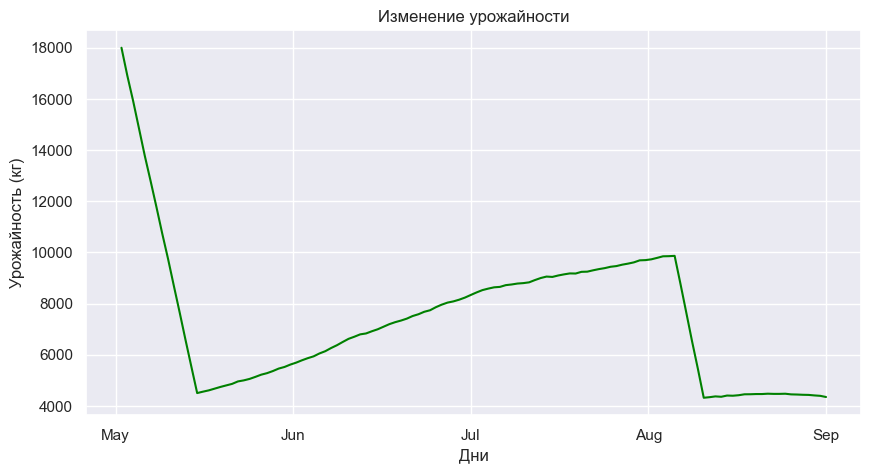

In [59]:
data = TimeLine.watcher["paddock_1_resource_history"]
# data = Cattle.cattle_stack[45].weight_history

indices = list(range(1, len(data) + 1))

custom_x_ticks = []

# Generate month labels for each month in the season duration
current_date = grazing.start_date
while current_date <= grazing.end_date+datetime.timedelta(days=30):
    custom_x_ticks.append(current_date.strftime("%b"))
    current_date = current_date + datetime.timedelta(days=30)  # Approximate number of days in a month

# Ensure the last label is "Sep" to match the season end date

# Remove duplicate month labels if any
custom_x_ticks = list(set(custom_x_ticks))

# Sort the month labels in chronological order
custom_x_ticks.sort(key=lambda x: datetime.datetime.strptime(x, "%b").month)
# Calculate the positions of the custom x ticks
# In this case, I'm spreading them evenly across the x-axis
custom_x_tick_positions = np.linspace(0, grazing.grazing_duration.days, len(custom_x_ticks))

# Create the plot
plt.figure(figsize=(10, 5))
# Set the custom x tick positions and labels
plt.xticks(custom_x_tick_positions, custom_x_ticks)

plt.plot(indices, data, color="green")
plt.xlabel("Дни")
plt.ylabel("Урожайность (кг)")
plt.title("Изменение урожайности")

plt.grid(True)
plt.show()
